In [1]:
%matplotlib notebook
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
local_dir = os.path.join("/DATA",os.environ.get("USER"),"MNIST_data")
os.makedirs(local_dir,mode=0o755, exist_ok=True)

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(local_dir, one_hot=True)

Extracting /DATA/marcin.kostur/MNIST_data/train-images-idx3-ubyte.gz
Extracting /DATA/marcin.kostur/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /DATA/marcin.kostur/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /DATA/marcin.kostur/MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
tf.reset_default_graph()

def discriminator(x):
    with tf.variable_scope('discriminator', reuse=True):
        h = tf.contrib.layers.fully_connected(x, 128)
        logit = tf.contrib.layers.fully_connected(h, 1, activation_fn=None)
        prob = tf.nn.sigmoid(logit)
    return prob, logit


def generator(z):
    with tf.variable_scope('generator'):
        h = tf.contrib.layers.fully_connected(z, 128)
        logit = tf.contrib.layers.fully_connected(h, 784, activation_fn=None)
        prob = tf.nn.sigmoid(logit)
    return prob
    

with tf.device('/gpu:0'):
    x = tf.placeholder(tf.float32, shape=[None, 784])  # real input
    z = tf.placeholder(tf.float32, shape=[None, 100])  # noise
    g_sample = generator(z)
    d_fake, d_logit_fake = discriminator(g_sample)
    d_real, d_logit_real = discriminator(x)
    
    d_vars = [t for t in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if 'discriminator' in t.name] 
    g_vars = [t for t in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if 'generator' in t.name] 
    
    d_loss_real = tf.reduce_mean(
        tf.losses.sigmoid_cross_entropy(
            tf.ones_like(d_logit_real),
            logits=d_logit_real))
    d_loss_fake = tf.reduce_mean(
        tf.losses.sigmoid_cross_entropy(
            tf.zeros_like(d_logit_fake),
            logits=d_logit_fake))
    d_loss = d_loss_real + d_loss_fake
    d_train = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
    
    # Generator is trying to maximize the loss of the discriminator.
    g_loss = tf.reduce_mean(
        tf.losses.sigmoid_cross_entropy(
            tf.ones_like(d_logit_fake),
            logits=d_logit_fake))
    g_train = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_vars)
    


In [5]:
len(d_vars), len(g_vars)

(4, 4)

In [6]:
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)
sess.run(init_op)

coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

<IPython.core.display.Javascript object>


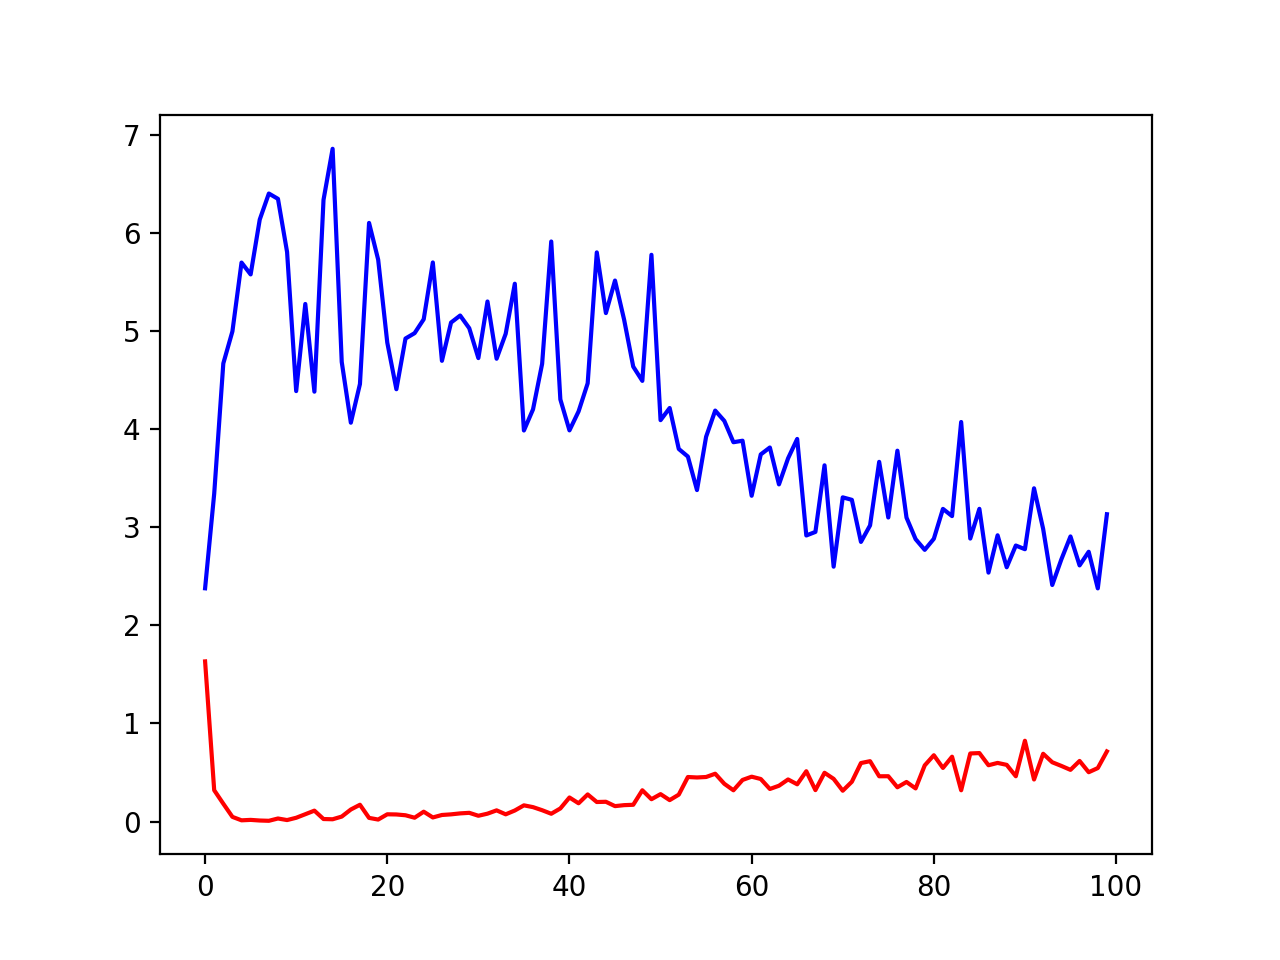

CPU times: user 2min 40s, sys: 37 s, total: 3min 17s
Wall time: 1min 21s


In [7]:
%%time 
dl = []  # discriminator loss
gl = []  # generator loss
fig, ax = plt.subplots(1,1)
batch_size = 128

for i in range(10000):
    images, labels = mnist.train.next_batch(batch_size)
    
    z_inst = np.random.uniform(-1., 1., size=[batch_size, 100])
    curr_dl, _ = sess.run([d_loss, d_train], feed_dict={x: images,
                                                        z: z_inst})
    
    z_inst = np.random.uniform(-1., 1., size=[batch_size, 100])
    curr_gl, _ = sess.run([g_loss, g_train], feed_dict={z: z_inst})
    
    if i % 100 == 0:
        dl.append(curr_dl)
        gl.append(curr_gl)
        ax.clear()
        ax.plot(dl,'r-')
        ax.plot(gl,'b-')
        fig.canvas.draw()


In [ ]:
prob, logit = sess.run(discriminator(x),feed_dict={x: images[:,:]})

In [ ]:
prob

In [ ]:
np.argwhere(prob<0.4)[:,0]

In [ ]:
import time 
fig, ax = plt.subplots(1,1)
for ith in np.argwhere(prob>0.9)[:,0]:
    plt.title("%04d %f"%(ith,prob[ith]))
    ax.matshow(images[ith,:].reshape((28,28)), cmap=plt.cm.binary)
    fig.canvas.draw()
    time.sleep(0.3)

In [16]:
z_inst = np.random.uniform(0.4, 1., size=[batch_size, 100])
fake_prob = sess.run(g_sample, feed_dict={z: z_inst})

In [17]:
fake_prob = fake_prob.reshape([batch_size, 28, 28])

In [18]:
fake_prob.shape

(128, 28, 28)

<IPython.core.display.Javascript object>


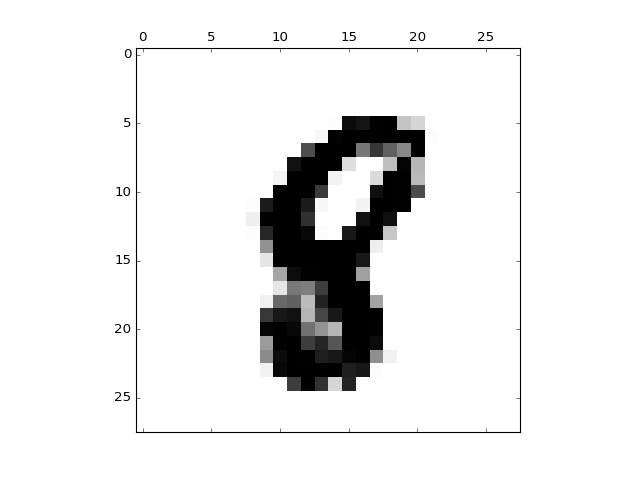

In [21]:
import time 
fig, ax = plt.subplots(1,1)
for ith in range(fake_prob.shape[0]):
    #plt.title("%04d %f"%(ith,prob[ith]))
    ax.matshow(fake_prob[ith,:], cmap=plt.cm.binary)
    fig.canvas.draw()
    time.sleep(0.3)

<IPython.core.display.Javascript object>


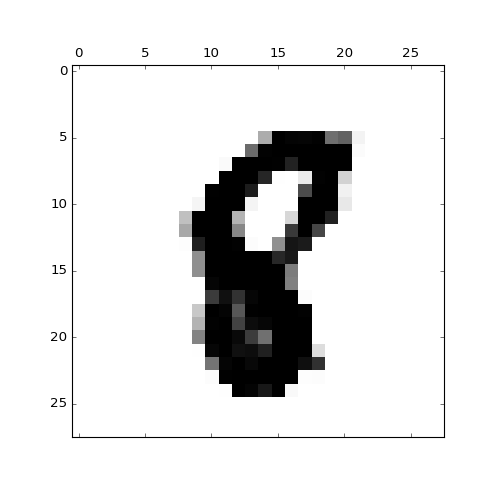

In [19]:
plt.matshow(fake_prob[14, ...], cmap=plt.cm.binary)

In [ ]:
plt.matshow(images.reshape([128, 28, 28])[0, ...], cmap=plt.cm.binary)